# Quickstart
In this tutorial we will setup a quick and simple simulation that gives us the occasion to show the basic features of cascade. For basic astrodynamics 
computations we make use of [pykep](https://esa.github.io/pykep/). We are going to simulate a random population of object in a Keplerian orbit around the Earth and monitor their collisions and conjunctions.

Let us start with some imports:

In [1]:
# core imports
import cascade as csc
import pykep as pk
import numpy as np
import heyoka as hy

# plotting
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
%matplotlib inline

## The dynamics

For this quickstart we will make use a simple non dimensional Keplerian dynamics and make use of the ``cascade.dynamics`` module to instantiate it.

Note that a dynamics is defined by tuples of [heyoka](https://bluescarni.github.io/heyoka.py/) expressions containing the state variable and the corresponding expression for its derivative defining the dynamics. 

Let us instantiate a simple Keplerian dynamics and inspect it:

In [2]:
dyn = csc.dynamics.kepler(mu = 1)
dyn

[(x, vx),
 (y, vy),
 (z, vz),
 (vx, (-x * pow((x**2 + y**2 + z**2), -1.5000000000000000))),
 (vy, (-y * pow((x**2 + y**2 + z**2), -1.5000000000000000))),
 (vz, (-z * pow((x**2 + y**2 + z**2), -1.5000000000000000)))]

# The initial conditions

As initial conditions we need to define the starting values for the state of all objects as well as their dimension, which will be used to define collisions. We make sure, for the purpose of this quickstart to define rather large particles as to make sure collisions would show up already early on.


In [3]:
N = 1000 # number of objects simulated
# The following numpy array will hold all the initial conditions and object radius [x,y,z,vx,vy,vz,r]
ic_state = np.zeros((N, 7))
# We generate randomly orbital parameters and imensions and transform them to Cartesian state. Note we make use of nondimensional units as defined in the dynamics.
for i in range(N):
    a = np.random.uniform(1.02, 1.3)
    e = np.random.uniform(0, 0.02)
    inc = np.random.uniform(np.pi/3, np.pi/3 + 0.05)
    om = np.random.uniform(0, 2*np.pi)
    Om = np.random.uniform(np.pi/3, np.pi/3 + 0.05)
    nu = np.random.uniform(0, 2*np.pi)
    size = np.random.uniform(1e-3/2, 1e-4)
    r, v = pk.par2ic([a, e, inc, Om, om, nu], mu = 1.)
    ic_state[i][:3] = r
    ic_state[i][3:6] = v
    ic_state[i][6] = size

... and we visualize them in proportion to a central body with radius 0.5

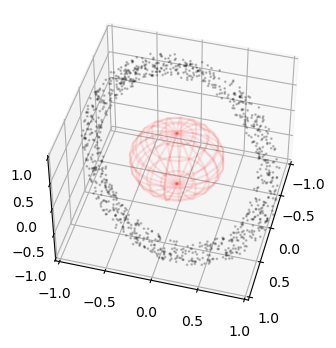

In [4]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, projection='3d')

r = 0.5
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
x = r*np.cos(u)*np.sin(v)
y = r*np.sin(u)*np.sin(v)
z = r*np.cos(v)
ax.plot_wireframe(x, y, z, color="r", alpha=0.1)

ax.scatter3D(ic_state[:,0], ic_state[:,1], ic_state[:,2], alpha=0.2, s= 1, c='k')

ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)

ax.view_init(45,15)

## Building the simulation

cascade main interface is offered via the object ``cascade.sim`` that is, essentially, a container for the dynamics of n-bodies that interact only via collisions and possible conjunctions. By default the simulation will track collision between all the objects. To activate conjunction tracking, minimal collision radii, object whitelists or reentry events, specific arguments need to be defined and are the subject of more advanced tutorials.

In [5]:
sim = csc.sim(state = ic_state, dyn=dyn, ct = 2*np.pi / 90)

the ``state`` kwarg initializes the initial conditions for the simulation. the ``dyn`` kwarg specifies the dynamics and the ``ct`` kwarg, called collisional timestep, a time interval that represents how frequently cascade resolves collisions and conjunctions between particles. Note that whatever the value of ``ct`` cascade guarantees the detection of all collisions and conjunctions, but according to its value the resulting cost of the guaranteed algorithm may vary greatly. 

## Running the simulation up to the first collision

In [6]:
# This will try to propagate all the orbits up to a collision event is triggered or the final time is reached
oc = sim.propagate_until(30 * np.pi)


here we have setup things so that a collision is almost certainly happening early on .... if thats the case the simulation outcome will be 'collision' and the information contained in the 
``interrup_info`` attribte will be the ids of the objects involved

In [7]:
time = sim.time
pi, pj = sim.interrupt_info
print("Outcome: ", oc.name)
print("Time: ", sim.time)
print("Particle", pi, "collided with particle", pj)

Outcome:  collision
Time:  39.08101616807163
Particle 479 collided with particle 648


At this point one can react to the collision adding fragments, removing particles, ignoring the collision etc.. to then start again the simulation. In this first tutorial we stop and 
visualize the collision position.

## Plotting the collision position

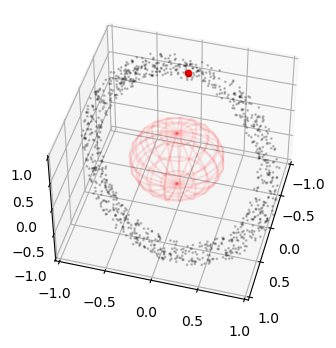

In [8]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, projection='3d')

r = 0.5
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
x = r*np.cos(u)*np.sin(v)
y = r*np.sin(u)*np.sin(v)
z = r*np.cos(v)
ax.plot_wireframe(x, y, z, color="r", alpha=0.1)

ax.scatter3D(ic_state[:,0], ic_state[:,1], ic_state[:,2], alpha=0.2, s= 1, c='k')
ax.scatter3D(sim.state[pi,0], sim.state[pi,1], sim.state[pi,2], alpha=1, s= 20, c='r')

ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)

ax.view_init(45,15)